# Spam Classification

### Import libraries

In [42]:
import torch
import time
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets
from transformers import DistilBertModel, DistilBertTokenizer, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [43]:
# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Loading Dataset

In [44]:
df = pd.read_csv('spam_transformers.csv')
df.head(4)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...


In [45]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [46]:
df.isna().sum()

Category    0
Message     0
dtype: int64

In [47]:
df['Category'] = df['Category'].map({'ham' : 0, 'spam' : 1 })
df.head(4)

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...


In [48]:
df['Category'].value_counts()

Category
0    4825
1     747
Name: count, dtype: int64

### Train/test split

In [49]:

X = df['Message']
y = df['Category']
X.head(3)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
Name: Message, dtype: object

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)
X_train, y_train

(1978    Reply to win £100 weekly! Where will the 2006 ...
 3989    Hello. Sort of out in town already. That . So ...
 3935     How come guoyang go n tell her? Then u told her?
 4078    Hey sathya till now we dint meet not even a si...
 4086    Orange brings you ringtones from all time Char...
                               ...                        
 3772    Hi, wlcome back, did wonder if you got eaten b...
 5191                               Sorry, I'll call later
 5226        Prabha..i'm soryda..realy..frm heart i'm sory
 5390                           Nt joking seriously i told
 860               Did he just say somebody is named tampa
 Name: Message, Length: 4457, dtype: object,
 1978    1
 3989    0
 3935    0
 4078    0
 4086    1
        ..
 3772    0
 5191    0
 5226    0
 5390    0
 860     0
 Name: Category, Length: 4457, dtype: int64)

In [51]:
len(X_train), len(X_test), len(y_train)

(4457, 1115, 4457)

### Tokenizer

In [52]:
from transformers import DistilBertModel, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fucn(texts, labels):
    encodings = tokenizer(texts, padding='max_length', max_length= 128, truncation= True, return_tensors='pt')
    return encodings['input_ids'], encodings['attention_mask'], torch.tensor(labels, dtype= torch.float)

tokenize_fucn(['hurry up, click now', 'Thesis meeting tomorrow'], [1, 0])

(tensor([[  101,  9241,  2039,  1010, 11562,  2085,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,   

### Dataset and Dataloaders

In [53]:
X_train.values.tolist()[:2]
y_train.values.tolist()[:2]

[1, 0]

In [54]:
train_input_ids, train_attention_mask, train_labels =tokenize_fucn(X_train.values.tolist(), y_train.values.tolist())
val_input_ids, val_attention_mask, val_labels =tokenize_fucn(X_test.values.tolist(), y_test.values.tolist())

In [55]:
train_input_ids[:2]

tensor([[  101,  7514,  2000,  2663, 27708,  4882,   999,  2073,  2097,  1996,
          2294,  5713,  2088,  2452,  2022,  2218,  1029,  4604,  2644,  2000,
          6584, 21926,  2683,  2000,  2203,  2326,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [56]:
train_labels[:2]

tensor([1., 0.])

In [57]:
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)

val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)

In [58]:
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [59]:
for input_ids, attention_mask, labels in train_loader:
    print(labels.shape)
    print(input_ids.shape)
    break

torch.Size([64])
torch.Size([64, 128])


### Bert Model

In [60]:
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
bert.config.hidden_size

768

In [61]:

# Define the Spam Classification Model using BERT
class spam_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pre-trained BERT model
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Freezing BERT parameters (not updating weights during training)
        for param in self.bert.parameters():
            param.requires_grad = False
        # Adding a custom classification head on top of BERT
        self.classifier = nn.Sequential(
            nn.Linear(bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    # Forward pass through the model
    def forward(self, input_ids, attention_mask )  :
          bert_output = self.bert(input_ids = input_ids, attention_mask = attention_mask)
          # Extract sentence embedding (CLS token representation)
          sentence_embedding = bert_output.last_hidden_state[:,0,:]
          # Pass embedding through classification head
          return self.classifier(sentence_embedding)

In [62]:
# Initialize the Spam Classification Model and move it to the appropriate device (GPU/CPU)
model = spam_classifier().to(device)
# Define the loss function
# - Since it's a binary classification problem (spam vs. ham),
#   we use Binary Cross Entropy Loss (BCELoss), which is suitable for probability outputs (Sigmoid activation).
criterion = nn.BCELoss().to(device)
# Define the optimizer
# - Adam optimizer is used for efficient weight updates.
# - Learning rate (lr) is set to 0.001 to control the step size during gradient updates.
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Model Traning

In [63]:
# Training loop
start = time.time()
epochs = 5
for epoch in range(epochs):
    model.train() # Set model to training mode
    running_loss = 0 # Track total loss for epoch
    # Iterate over training batches
    for batch_num, (input_ids, attention_mask, labels) in enumerate(train_loader) :
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        # Forward pass: get model predictions
        output = model(input_ids, attention_mask).squeeze()
        # Compute loss using the specified criterion (e.g., Binary Cross Entropy)
        loss = criterion(output, labels)
        # Backpropagation: update model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()   # Accumulate batch loss
        # Print loss every 20 batches
        if (batch_num + 1) % 20 == 0:
                print(f'Batch:{batch_num+1}, Epoch :{epoch+1}, Loss: {loss.item():0.2f}')
    
    end = time.time()
    print(f'Excecution time:{end - start} seconds')
    
    # Compute average loss for the epoch
    epoch_loss = running_loss/len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Avg loss: {epoch_loss:.4f}")

Batch:20, Epoch :1, Loss: 0.16
Batch:40, Epoch :1, Loss: 0.14
Batch:60, Epoch :1, Loss: 0.07
Excecution time:43.342825412750244 seconds
Epoch 1/5, Avg loss: 0.1479
Batch:20, Epoch :2, Loss: 0.05
Batch:40, Epoch :2, Loss: 0.08
Batch:60, Epoch :2, Loss: 0.13
Excecution time:87.49668836593628 seconds
Epoch 2/5, Avg loss: 0.0501
Batch:20, Epoch :3, Loss: 0.01
Batch:40, Epoch :3, Loss: 0.02
Batch:60, Epoch :3, Loss: 0.01
Excecution time:131.96429538726807 seconds
Epoch 3/5, Avg loss: 0.0429
Batch:20, Epoch :4, Loss: 0.01
Batch:40, Epoch :4, Loss: 0.10
Batch:60, Epoch :4, Loss: 0.16
Excecution time:176.65982937812805 seconds
Epoch 4/5, Avg loss: 0.0368
Batch:20, Epoch :5, Loss: 0.09
Batch:40, Epoch :5, Loss: 0.03
Batch:60, Epoch :5, Loss: 0.01
Excecution time:221.45043754577637 seconds
Epoch 5/5, Avg loss: 0.0366


### Testing Model

In [64]:
model.eval()
y_pred = []
y_true = []
total_loss = 0
correct_predictions = 0
with torch.no_grad():
    for input_ids, attention_mask, labels in val_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        output = model(input_ids, attention_mask).squeeze()
        loss = criterion(output, labels)
        total_loss += loss.item()
        # Convert model output to binary predictions (0 or 1)
        prediction = (output > 0.5).float()
        correct_predictions += torch.sum(prediction == labels)
        # Store true and predicted labels for classification report
        y_true.extend(labels.cpu().numpy())  # Convert tensor to numpy
        y_pred.extend(prediction.cpu().numpy())  # Convert tensor to numpy

    # Compute average loss and validation accuracy
    avg_loss = total_loss/len(val_loader)
    val_accuracy = correct_predictions.double()/len(val_dataset)
    print(f'validation loss :{avg_loss} , validation accuaracy: {val_accuracy}')

validation loss :0.037684734729636044 , validation accuaracy: 0.9910313901345291


### Evaluation

In [65]:
# Generate Classification Report

report = classification_report(y_true, y_pred, target_names=["Ham", "Spam"])
print(report)

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       966
        Spam       0.99      0.94      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



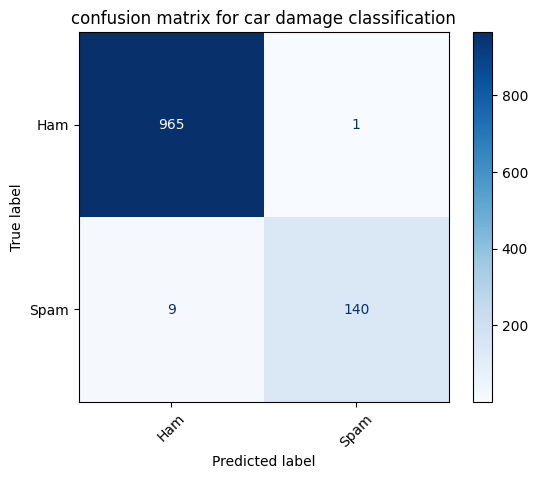

In [66]:

# Define class names
class_names = ["Ham", "Spam"]

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels= np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('confusion matrix for car damage classification')
plt.show()

### Prediction

In [69]:
def predict(model, text, max_length = 128 ):
    
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    # Tokenize input text
    encodings = tokenizer(text, padding='max_length', max_length= max_length, truncation= True, return_tensors='pt')
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    model = spam_classifier().to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_ids, attention_mask).squeeze()
        prediction = (output > 0.5).float().item()
        return 'spam' if prediction == 1 else 'ham'

In [70]:
predict(model, 'win iphone, click here')

'spam'

In [71]:
predict(model, 'dhl packet outfor delivery')

'ham'

In [72]:
predict(model, 'Dear Joyal, i hope see you on monday')

'ham'